# Libraries and Configuration Settings

As a first step, we will import the required libraries and will configure values for different parameters that we will be using in the code. Let's first import the required libraries:

In [1]:

import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


Execute the following script to set values for different parameters:

In [2]:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 25000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 25000
EMBEDDING_SIZE = 100

# Data Preprocessing
Neural machine translation models are often based on the seq2seq architecture. The seq2seq architecture is an encoder-decoder architecture which consists of two LSTM networks: the encoder LSTM and the decoder LSTM. The input to the encoder LSTM is the sentence in the original language; the input to the decoder LSTM is the sentence in the translated language with a start-of-sentence token. 

The output is the actual target sentence with an end-of-sentence token.
In our dataset, we do not need to process the input, however, we need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token. Here is the script which does that:

In [3]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open(r'C:\Users\Paaras Jamwal\Dropbox\My PC (PAARAS)\Desktop\Project\fra.txt', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence, output, attrib = line.rstrip().split('\t')

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))
print("num samples output input:", len(output_sentences_inputs))

num samples input: 25000
num samples output: 25000
num samples output input: 25000


Let's now randomly print a sentence from the input_sentences[], output_sentences[], and output_sentences_inputs[] lists

In [4]:
print(input_sentences[111])
print(output_sentences[111])
print(output_sentences_inputs[111])

Drop it!
Laisse-le tomber ! <eos>
<sos> Laisse-le tomber !


# Tokenization and Padding
The tokenizer class performs two tasks:

   It divides a sentence into the corresponding list of word
   Then it converts the words to integers
For tokenization, the Tokenizer class from the keras.preprocessing.text library can be used.
    

The following script is used to tokenize the input sentences:

In [5]:
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 4014
Length of longest sentence in input: 6


The output sentences can also be tokenized in the same way as shown below:

In [6]:
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 11128
Length of longest sentence in the output: 13


Next, we need to pad the input. The reason behind padding the input and the output is that text sentences can be of varying length, however LSTM (the algorithm that we are going to train our model) expects input instances with the same length. Therefore, we need to convert our sentences into fixed-length vectors. One way to do this is via padding.

In padding, a certain length is defined for a sentence. In our case the length of the longest sentence in the inputs and outputs will be used for padding the input and output sentences, respectively. The longest sentence in the input contains 6 words. For the sentences that contain less than 6 words, zeros will be added in the empty indexes. The following script applies padding to the input sentences

In [7]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[111]:", encoder_input_sequences[111])

encoder_input_sequences.shape: (25000, 6)
encoder_input_sequences[111]: [  0   0   0   0 426   5]


In [8]:
print(word2idx_inputs["drop"])
print(word2idx_inputs["it"])

426
5


In the same way, the decoder outputs and the decoder inputs are padded as follows:

In [9]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[111]:", decoder_input_sequences[111])

decoder_input_sequences.shape: (25000, 13)
decoder_input_sequences[111]: [  2 929 425   5   0   0   0   0   0   0   0   0   0]


In [10]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["laisse-le"])
print(word2idx_outputs["tomber"])
print(word2idx_outputs["!"])


2
929
425
5


# Word Embeddings
In word embeddings, every word is represented as an n-dimensional dense vector. The words that are similar will have similar vector. Word embeddings techniques such as GloVe and Word2Vec have proven to be extremely efficient for converting words into corresponding dense vectors. The vector size is small and none of the indexes in the vector is actually empty.
There are two main differences between single integer representation and word embeddings. With integer reprensentation, a word is represented only with a single integer. With vector representation a word is represented by a vector of 50, 100, 200, or whatever dimensions you like. Hence, word embeddings capture a lot more information about words. Secondly, the single-integer representation doesn't capture the relationships between different words.


--> Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values, as shown below:

In [11]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'C:\Users\Paaras Jamwal\Dropbox\My PC (PAARAS)\Desktop\Project\glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

We will create a matrix where the row number will represent the integer value for the word and the columns will correspond to the dimensions of the word. This matrix will contain the word embeddings for the words in our input sentences.

In [12]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Let's first print the word embeddings for the word "drop" using the GloVe word embedding dictionary.

In [13]:
print(embeddings_dictionary["drop"])

[ 0.2934     0.49122    0.021428  -0.0032031 -0.30625   -0.70369
 -0.02503    0.20014   -0.11357    0.20024   -0.096917   0.24
 -0.43177    0.12703    0.50062    0.33529   -0.84563    0.23978
 -0.094769   0.20813    0.85062   -0.14943   -0.10232    0.74019
  0.11983   -0.11003   -0.33117   -0.31358   -0.12285   -0.76261
  0.29028   -0.0053144 -0.14366    0.14945   -0.25026    0.51785
  0.47238   -0.2494     0.069556   0.041659  -0.49759   -0.17819
 -0.16676   -0.062862   0.55204    0.026228  -0.029453  -0.35108
 -0.16275   -1.4509     0.52228    0.044831  -0.25485    0.95877
 -0.11863   -2.002     -0.29194   -0.22581    2.1544     0.17959
  0.052697  -0.022561  -0.47654    0.27268    0.15112    0.13092
  0.17475   -0.20071    0.12448   -0.05814   -0.12978    0.24495
 -0.11701    0.22073   -0.061256   0.015408  -0.33155   -0.020674
  0.13623    0.24073    0.63338   -0.11291   -0.75424   -0.27938
 -0.85368   -1.7428     0.2717    -0.23938    0.3652     0.1187
 -0.28925    0.41028   -0.70

In [14]:
print(embedding_matrix[340])

[-0.04352    -0.14816999  0.4887     -0.73157001 -0.27412    -0.2209
 -0.3089     -0.27377    -0.60622001 -0.70490003  0.10406     0.57046998
  0.015561   -0.23216     0.48221999  0.27009001 -0.085793    0.6049
 -0.34283999  0.55571002  0.47641999  0.032829    0.41442999 -0.81572998
  0.80233997  0.66843998 -0.99586999 -0.10888     0.27638999 -0.29908001
 -0.80385     0.39616001  0.015443    0.36917999  0.25073001  0.15033001
 -0.65483999  0.1781      0.22781999  0.16301    -0.26587999  0.054827
 -0.17984    -0.25613999  0.11202     0.35409001  0.35001999 -0.59873003
 -0.48477    -0.36230999 -0.10032     0.74190998 -0.19666     0.96941
 -0.25966999 -1.77740002 -0.95845997  0.14345001  1.47029996  0.098012
 -0.71111     0.28937    -0.20434     0.22107001  0.40270999  0.17397
  0.75147003 -0.36158001  0.14086001 -0.085578   -0.54237002 -0.48543
  0.43897    -0.040572   -0.24056999 -0.16117001 -0.96548998 -0.16031
  0.68133998  0.31393     0.66152     0.0049498  -0.45455    -0.51831001
 -

This word embedding matrix will be used to create the embedding layer for our LSTM model.

The following script creates the embedding layer for the input:

In [15]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

# Phase 2 
# Creating the Model

The following script creates the empty output array:

In [16]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

The following script prints the shape of the decoder:

In [17]:
decoder_targets_one_hot.shape

(25000, 13, 11129)

To make predictions, the final layer of the model will be a dense layer, therefore we need the outputs in the form of one-hot encoded vectors, since we will be using softmax activation function at the dense layer. To create such one-hot encoded output, the next step is to assign 1 to the column number that corresponds to the integer representation of the word. For instance, the integer representation for <sos> je suis malade is [ 2 3 6 188 0 0 0 0 0 0 0 ]. In the decoder_targets_one_hot output array, in the second column of the first row, 1 will be inserted. Similarly, at the third index of the second row, another 1 will be inserted, and so on.

In [18]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

In [19]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

Next, we need to create the encoder and decoders. The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the LSTM.

The following script defines the encoder:

In [20]:
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with an <sos> token appended at the beginning.

The following script creates the decoder LSTM

In [21]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

Finally, the output from the decoder LSTM is passed through a dense layer to predict decoder outputs, as shown here

In [22]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

The next step is to compile the model:

In [23]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Let's plot our model to see how it looks:

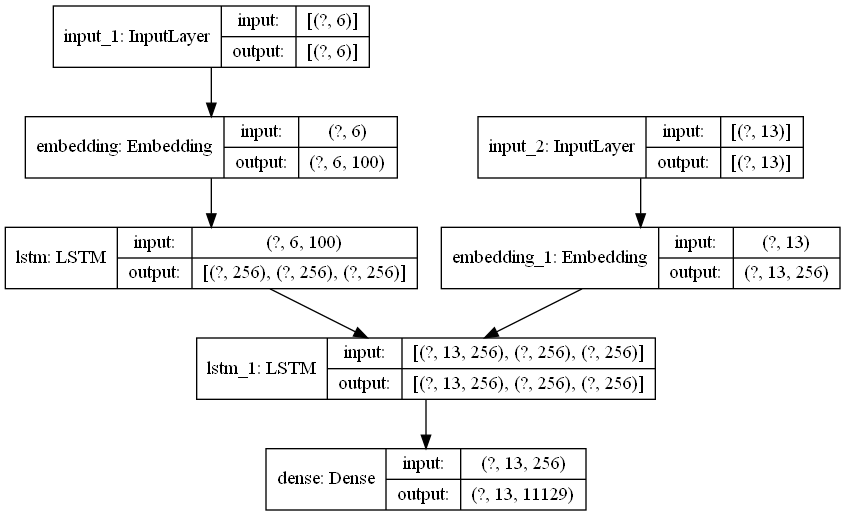

In [24]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

From the output, you can see that we have two types of input. input_1 is the input placeholder for the encoder, which is embedded and passed through lstm_1 layer, which basically is the encoder LSTM. There are three outputs from the lstm_1 layer: the output, the hidden layer and the cell state. However, only the cell state and the hidden state are passed to the decoder.

Here the lstm_2 layer is the decoder LSTM. The input_2 contains the output sentences with <sos> token appended at the start. The input_2 is also passed through an embedding layer and is used as input to the decoder LSTM, lstm_2. Finally, the output from the decoder LSTM is passed through the dense layer to make predictions.


The next step is to train the model using the fit() method:

In [25]:
filename = 'model.h1.20_mar_21'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[checkpoint], verbose=1
)

Epoch 1/20
352/352 [==============================] - ETA: 0s - loss: 2.0259 - accuracy: 0.7178
Epoch 00001: val_loss improved from inf to 2.02030, saving model to model.h1.20_mar_21
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.h1.20_mar_21\assets
352/352 [==============================] - 152s 433ms/step - loss: 2.0259 - accuracy: 0.7178 - val_loss: 2.0203 - val_accuracy: 0.7082
Epoch 2/20
352/352 [==============================] - ETA: 0s - loss: 1.4858 - accuracy: 0.7791
Epoch 00002: val_loss improved from 2.02030 to 1.74573, saving model to model.h1.20_mar_21
INFO:tensorflow:Assets written to: model.h1.20_mar_21\assets
352/352 [==============================] - 161s 456ms/step - loss: 1.4858 - accuracy: 0.7791 - val_loss: 1.7457 - val_accuracy: 0.7427
Epoc

# Modifying the Model for Predictions

In [35]:
model = load_model('model.h1.20_mar_21')
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

Since now at each step we need the decoder hidden and cell states, we will modify our model to accept the hidden and cell states as shown below:

In [36]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

Now at each time step, there will be only single word in the decoder input, we need to modify the decoder embedding layer as follows:



In [37]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

Next, we need to create the placeholder for decoder outputs:

In [38]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

To make predictions, the decoder output is passed through the dense layer:

In [39]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

The final step is to define the updated decoder model, as shown here:

In [40]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

Let's now plot our modified decoder LSTM that makes predictions:

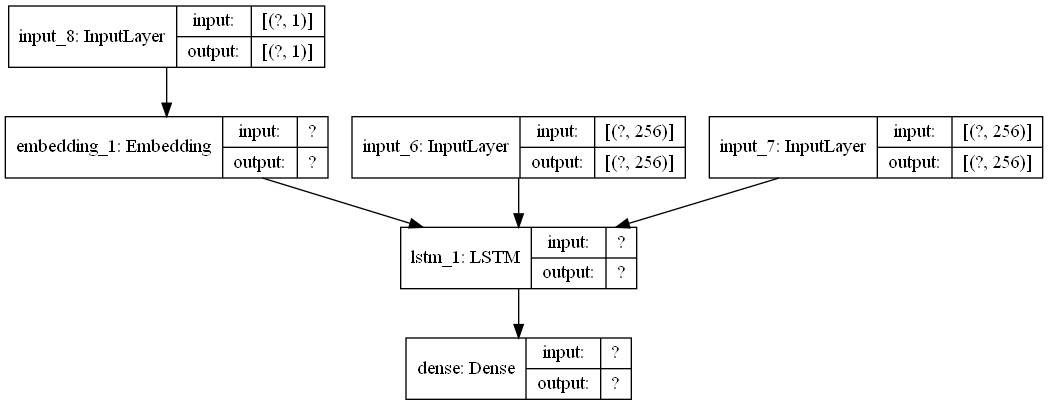

In [41]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

# Making Predictions

In [42]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [43]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

# Testing the Model

In [51]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

-
Input: I looked away.
Response: j'ai aimé la maison.


In [37]:
 model.save_weights('saved_weights.hdf5', overwrite=True)

model.load_weights("saved_weights.hdf5")